### TABLE CREATION

In [1]:
from CreateTable import create_df

data = create_df()
data.head()

Sample processing:   0%|          | 0/6562 [00:00<?, ?it/s]

,Source,posx,posy,posz,Stiffness,Tau,Force Steady State,Power,Entropy,Upstroke,...,poly5_coef4,segment2_slope,segment3_slope,segment2_force_std,segment3_force_std,segment2_skew,segment3_skew,cubic_coefficient,quartic_coefficient,poly5_coef5
0,1,100.0,100.0,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",330.145636,38.742032,0.677192,0.118082,-3668.446016,3.040855,...,-1.051531,1.688896,324.466911,0.001955,0.213030,-0.145240,0.098379,5.071858e+06,6.979549e+08,0.022597
1,10,100.0,102.0,"[82.994, 83.0, 82.999, 82.999, 82.999, 82.999,...",279.615514,31.633202,0.611338,0.096320,-2624.046985,2.736309,...,-1.410526,11.863045,277.345167,0.004163,0.194823,3.461017,-0.016304,4.270015e+06,3.978508e+08,0.028631
2,100,96.0,96.0,"[82.999, 82.999, 82.999, 82.999, 83.0, 82.999,...",238.795815,28.067472,0.564735,0.081695,-2542.084820,2.386378,...,-1.567287,25.396163,240.398354,0.011108,0.171779,3.206635,-0.058821,3.439680e+06,1.763606e+08,0.025178
3,1000,84.0,108.0,"[82.999, 82.999, 83.0, 83.0, 82.999, 82.999, 8...",212.753492,28.080585,0.509022,0.067157,-2562.547617,2.135226,...,-1.815683,34.011009,214.694554,0.016077,0.146172,2.890025,-0.063862,3.240457e+06,1.250021e+08,0.035414
4,1001,108.0,84.0,"[82.999, 82.999, 82.999, 82.999, 82.999, 82.99...",203.576928,27.230195,0.498891,0.062726,-2387.728182,2.059975,...,-1.656116,22.638929,207.167720,0.010213,0.152682,3.501849,-0.092539,2.773912e+06,1.345924e+08,0.033329


### PLOTS

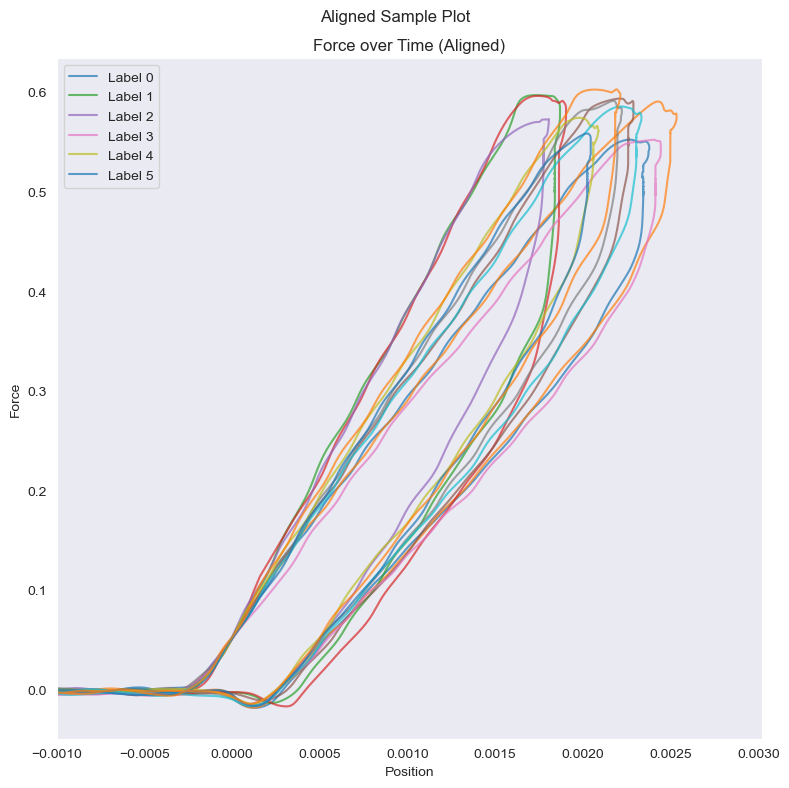

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample


def plot_aligned_samples(df, label_column, force_column, pos_column, threshold=0.1, max_samples_per_label=5):
    unique_labels = (0, 1, 2, 3, 4, 5)

    fig, axes = plt.subplots(1, 1, figsize=(8, 8))

    used_labels = set()  # Track labels for legend

    for label in unique_labels:
        # Get all samples for this label
        label_df = df[df[label_column] == label]

        # Downsample if too many samples
        if len(label_df) > max_samples_per_label:
            label_df = resample(label_df, n_samples=max_samples_per_label, random_state=42)

        for _, sample in label_df.iterrows():
            # Extract force and position
            force = np.array(sample[force_column])
            position = np.array(sample[pos_column])

            # Find alignment point
            force_above_threshold = force > threshold
            if np.any(force_above_threshold):
                start_idx = np.where(force_above_threshold)[0][0]

                # Label only the first occurrence of each label
                label_text = f'Label {label}' if label not in used_labels else None
                used_labels.add(label)

                # Plot aligned data
                axes.plot(position - position[start_idx], force, label=label_text, alpha=0.7)

    # Set plot properties
    axes.set_xlabel('Position')
    axes.set_xlim(left=-0.001)
    axes.set_ylabel('Force')
    axes.set_title('Force over Time (Aligned)')
    axes.legend()
    axes.grid()

    plt.suptitle('Aligned Sample Plot')
    plt.tight_layout()
    plt.show()


# Example usage
plot_aligned_samples(data, label_column='label', force_column='Fi', pos_column='Pi', threshold=0.05,
                     max_samples_per_label=2)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_aligned_samples(df, label_column, force_column, pos_column, time_column, n=1, threshold=0.1):
    unique_labels = df[label_column].unique()  # Get unique labels
    unique_labels = (0, 1, 2, 3, 4, 5)

    for i in range(n):  # Repeat n times
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

        for label in unique_labels:
            # Randomly select one sample per label
            sample = df[df[label_column] == label].sample(1, random_state=np.random.randint(0, 10000))

            # Extract force, position, and time
            force = np.array(sample[force_column].tolist()[0])
            position = np.array(sample[pos_column].tolist()[0])
            time = np.array(sample[time_column].tolist()[0])

            # Find the first index where force rises above the threshold
            start_idx = np.where(force > threshold)[0][0]

            # Align the time axis so that this point is at t = 0
            time_aligned = time - time[start_idx]

            # Plot force vs. time (left subplot)
            axes[0].plot(time_aligned, force, label=f'Label {label}')
            axes[0].set_xlabel('Time (Aligned)')
            axes[0].set_ylabel('Force')
            axes[0].set_title('Force over Time (Aligned)')
            axes[0].legend()
            axes[0].grid()

            # Plot position vs. time (right subplot)
            axes[1].plot(time_aligned, position, label=f'Label {label}')
            axes[1].set_xlabel('Time (Aligned)')
            axes[1].set_ylabel('Position')
            axes[1].set_title('Position over Time (Aligned)')
            axes[1].legend()
            axes[1].grid()

        plt.suptitle(f'Aligned Sample Plot {i + 1}')
        plt.tight_layout()
        plt.show()


# Example usage
plot_aligned_samples(data, label_column='label', force_column='Fi', pos_column='Pi', time_column='Timei', n=2,
                     threshold=0.05)

### SPATIAL SMOOTHING

In [3]:
from scipy.interpolate import NearestNDInterpolator
from scipy.ndimage import median_filter, gaussian_filter
import numpy as np
import pandas as pd
from helper import *

smoothing_config = {
    'Entropy': 'gaussian',
} # Dictionary 'feature-name' : type of smoothing (set if you want to test other method of smoothing instead of median)

def apply_smoothing(grid_z, method='median'):
    """
    Apply different smoothing techniques to the grid

    Parameters:
    -----------
    grid_z : numpy.ndarray
        Input grid to be smoothed
    method : str, optional (default='median')
        Smoothing method to use. Options:
        - 'median': Median filter
        - 'gaussian': Gaussian filter
        - 'diffusion': Anisotropic diffusion

    Returns:
    --------
    numpy.ndarray
        Smoothed grid
    """
    if method == 'median':
        return median_filter(grid_z, size = 3, mode = 'reflect')

    elif method == 'gaussian':
        return gaussian_filter(grid_z, sigma = 2)

    elif method == 'diffusion':
        # Simple anisotropic diffusion
        def diffusion_step(img, kappa=50):
            """
            Perform a single diffusion step
            """
            # Compute image gradients
            dy, dx = np.gradient(img)

            # Compute diffusion coefficients
            diff_coef_x = 1 / (1 + (dx/kappa)**2)
            diff_coef_y = 1 / (1 + (dy/kappa)**2)

            # Compute diffusion
            diff_x = np.zeros_like(img)
            diff_y = np.zeros_like(img)

            diff_x[1:-1, 1:-1] = diff_coef_x[1:-1, 1:-1] * (img[1:-1, 2:] - img[1:-1, 1:-1])
            diff_y[1:-1, 1:-1] = diff_coef_y[1:-1, 1:-1] * (img[2:, 1:-1] - img[1:-1, 1:-1])

            return img + 0.25 * (diff_x + diff_y)

        # Apply multiple diffusion steps
        iterations = 20
        img = grid_z.copy()
        for i in range(iterations):
            img = diffusion_step(img)
        return img

    else:
        raise ValueError(f"Smoothing method not implemented: {method}")

def get_grid_bounds(df):
    x_min, x_max = int(df["posx"].min()), int(df["posx"].max())
    y_min, y_max = int(df["posy"].min()), int(df["posy"].max())
    grid_shape = (y_max - y_min + 1, x_max - x_min + 1)
    return x_min, y_min, grid_shape

# Smoothing function for a single dataframe
def smooth_subset(subset_df, x_min, y_min, grid_shape):
    smoothed_subset = pd.DataFrame(index=subset_df.index)

    for feature in feature_list:
        # Initialize grid with NaNs
        grid_z = np.full(grid_shape, np.nan, dtype=np.float32)

        # Map each data point to the grid
        for _, row in subset_df.iterrows():
            x_idx = int(row["posx"]) - x_min
            y_idx = int(row["posy"]) - y_min
            grid_z[y_idx, x_idx] = row[feature]

        # Interpolate missing values
        yy, xx = np.indices(grid_z.shape)
        valid_mask = ~np.isnan(grid_z)

        if np.any(~valid_mask):
            interpolator = NearestNDInterpolator(
                np.column_stack((yy[valid_mask], xx[valid_mask])),
                grid_z[valid_mask]
            )
            grid_z = interpolator(yy, xx)

        # Apply feature-specific smoothing
        methods = smoothing_config.get(feature, 'median') # Get the designed methods, if None select defaul 'median' method
        if isinstance(methods, list):
            for method in methods:
                grid_z = apply_smoothing(grid_z, method=method)
        else:
            grid_z = apply_smoothing(grid_z, method=methods)
        # Map smoothed grid back to DataFrame
        smoothed_subset[feature] = [
            grid_z[int(row["posy"]) - y_min, int(row["posx"]) - x_min]
            for _, row in subset_df.iterrows()
        ]

    # Add back metadata columns
    smoothed_subset[['label', 'posx', 'posy','Row']] = subset_df[['label', 'posx', 'posy','Row']]
    return smoothed_subset

if smoothing_config is None:
    smoothing_config = {feature: 'median' for feature in feature_list}

# Split data into train (posy < 90), train (posy > 110), and test
test_df = data[data['Row'] == 'Test']
train_df_lower = data[(data['Row'] == 'Train') & (data['posy'] < 90)]
train_df_upper = data[(data['Row'] == 'Train') & (data['posy'] > 110)]

# Compute grid bounds and smooth each subset
test_x_min, test_y_min, test_grid_shape = get_grid_bounds(test_df)
train_lower_x_min, train_lower_y_min, train_lower_grid_shape = get_grid_bounds(train_df_lower)
train_upper_x_min, train_upper_y_min, train_upper_grid_shape = get_grid_bounds(train_df_upper)

# Smooth each subset SEPARATELY
smoothed_test = smooth_subset(test_df, test_x_min, test_y_min, test_grid_shape)
smoothed_train_lower = smooth_subset(train_df_lower, train_lower_x_min, train_lower_y_min, train_lower_grid_shape)
smoothed_train_upper = smooth_subset(train_df_upper, train_upper_x_min, train_upper_y_min, train_upper_grid_shape)

smoothed_train = pd.concat([smoothed_train_lower, smoothed_train_upper], ignore_index=True)

smoothed_df = pd.concat([smoothed_test, smoothed_train], ignore_index=True) # For visualization in the next sections only

DISTRIBUTION OF FEATURES ACROSS DIFFERENT LABEL

Class distribution in the dataset:
Label 0: 4536 samples (69.15%)
Label 1: 405 samples (6.17%)
Label 2: 405 samples (6.17%)
Label 3: 404 samples (6.16%)
Label 4: 405 samples (6.17%)
Label 5: 405 samples (6.17%)


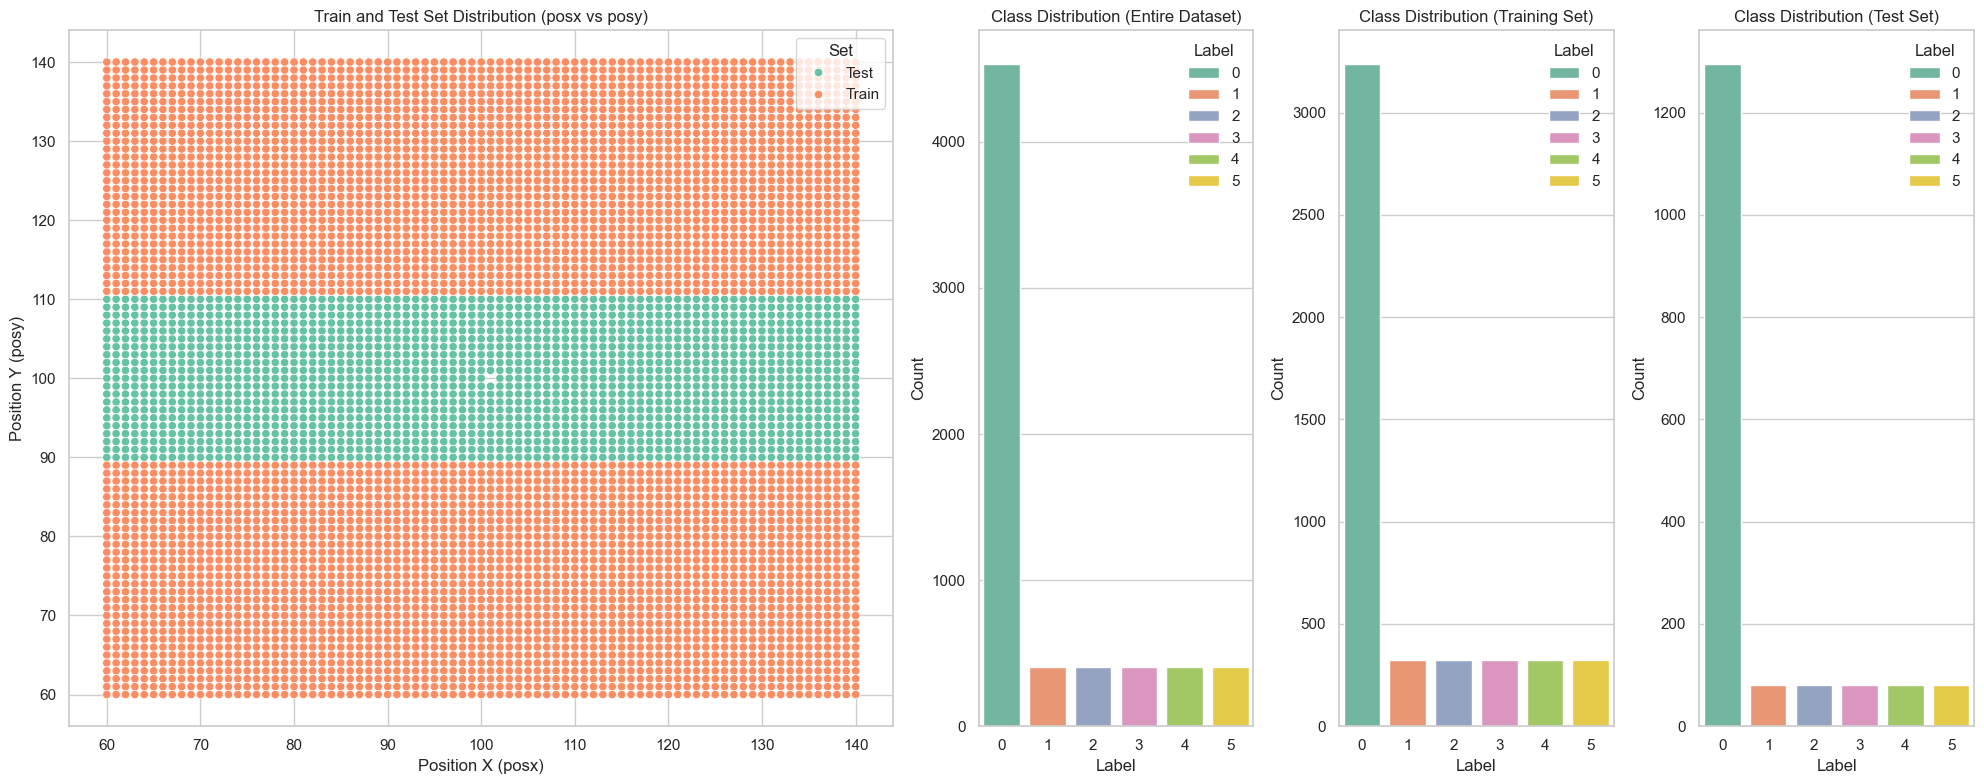

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score
from imblearn.over_sampling import ADASYN
import warnings
from sklearn.exceptions import UndefinedMetricWarning
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

# Display class distribution
X = smoothed_df[feature_list + ["posx", "posy"]]
y = smoothed_df['label']
class_distribution = Counter(y)
print("Class distribution in the dataset:")
for label, count in sorted(class_distribution.items()):
    print(f"Label {label}: {count} samples ({count / len(y) * 100:.2f}%)")

# Prepare data for classification
X_train = smoothed_train[feature_list + ["posx", "posy"]]
y_train = smoothed_train['label']
X_test = smoothed_test[feature_list + ["posx", "posy"]]
y_test = smoothed_test['label']

# Preprocess data  -  No need a scaler in Random FOREST!!!!, if other model, apply after the splitting
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
X_train_scaled = X_train
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_list + ["posx", "posy"], index=X.index)
X_test_scaled = X_test
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_list + ["posx", "posy"], index=X.index)

# Create the figure and axes for the big plot and the smaller ones
fig, axs = plt.subplots(1, 4, figsize=(20, 8), gridspec_kw={'width_ratios': [3, 1, 1, 1]})

# Set plot style
sns.set(style="whitegrid")

# Main plot for posx vs posy (Train vs Test)
sns.scatterplot(data=smoothed_df, x='posx', y='posy', hue='Row', palette='Set2', ax=axs[0])
axs[0].set_title("Train and Test Set Distribution (posx vs posy)")
axs[0].set_xlabel("Position X (posx)")
axs[0].set_ylabel("Position Y (posy)")
axs[0].legend(title='Set')

plot_class_distribution(smoothed_df['label'], axs[1], "Class Distribution (Entire Dataset)")
plot_class_distribution(y_train, axs[2], "Class Distribution (Training Set)")
plot_class_distribution(y_test, axs[3], "Class Distribution (Test Set)")

plt.tight_layout()
plt.show()

# # Drop posx and posy columns from the training and testing sets after plotting
# X_train = X_train.drop(columns=['posx', 'posy'])
# X_test = X_test.drop(columns=['posx', 'posy'])


Class distribution after ADASYN:
Label 0: 3240 samples (16.69%)
Label 1: 3267 samples (16.83%)
Label 2: 3198 samples (16.47%)
Label 3: 3278 samples (16.89%)
Label 4: 3216 samples (16.57%)
Label 5: 3213 samples (16.55%)

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.93      0.65      0.76      1296
           1       0.51      0.95      0.67        81
           2       0.42      0.73      0.53        81
           3       0.42      0.59      0.49        80
           4       0.24      0.54      0.33        81
           5       0.34      0.90      0.49        81

    accuracy                           0.67      1700
   macro avg       0.48      0.73      0.55      1700
weighted avg       0.80      0.67      0.70      1700



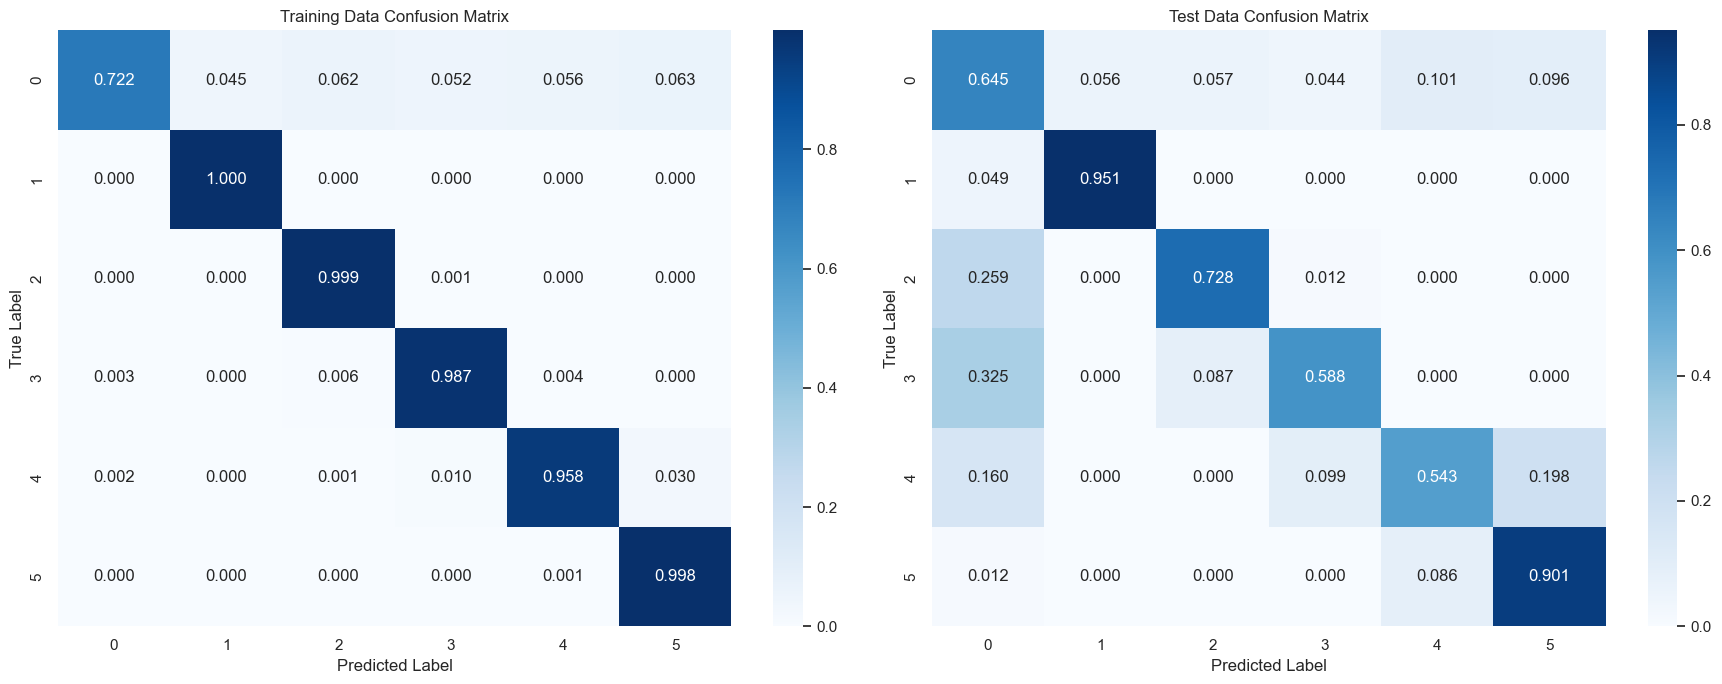

In [6]:
# Create dataset with selected features (no posx, posy)
X_train_selected = X_train[feature_list]
X_test_selected = X_test[feature_list]

# Apply ADASYN for adaptive oversampling
adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=5)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_selected, y_train)

# Display new class distribution after ADASYN
adasyn_class_distribution = Counter(y_train_adasyn)
print("\nClass distribution after ADASYN:")
for label, count in sorted(adasyn_class_distribution.items()):
    print(f"Label {label}: {count} samples ({count / len(y_train_adasyn) * 100:.2f}%)")

# Train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=5,
    bootstrap=True,
    criterion='entropy',
    class_weight=None,
    random_state=42,
    max_features=0.5,
    n_jobs=-1,
)

# Fit the model
rf_model.fit(X_train_adasyn, y_train_adasyn)

# Make predictions on training data
y_train_pred = rf_model.predict(X_train_adasyn)

# Make predictions on test data
y_test_pred = rf_model.predict(X_test_selected)

# Evaluate the model on test data
print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_test_pred, zero_division=0))

# Calculate performance metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train_adasyn, y_train_pred)
train_balanced_acc = balanced_accuracy_score(y_train_adasyn, y_train_pred)


# Function to create and plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)  # Replace NaN with 0

    sns.heatmap(cm_norm, annot=True, fmt='.3f', cmap='Blues', xticklabels=sorted(np.unique(y)),
                yticklabels=sorted(np.unique(y)), ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')


# Create a figure with two subplots for the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot confusion matrices for training and test data
plot_confusion_matrix(y_train_adasyn, y_train_pred, 'Training Data Confusion Matrix', ax1)
plot_confusion_matrix(y_test, y_test_pred, 'Test Data Confusion Matrix', ax2)

plt.tight_layout()
plt.show()

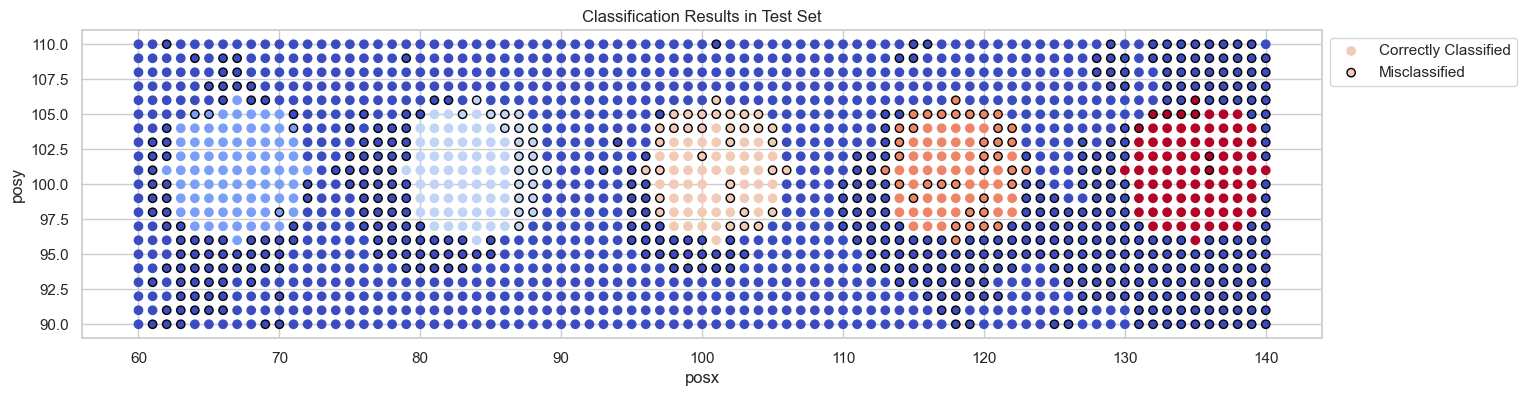

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Extract posx and posy from X_test
posx = X_test['posx']
posy = X_test['posy']

# Identify misclassified points
misclassified = y_test != y_test_pred

# Create the scatter plot
plt.figure(figsize=(16, 4))

# Plot correctly classified points (colored by true labels)
scatter1 = plt.scatter(posx[~misclassified], posy[~misclassified], c=y_test[~misclassified], cmap='coolwarm', marker='o', label='Correctly Classified')

# Plot misclassified points with black edges (colored by true labels)
scatter2 = plt.scatter(posx[misclassified], posy[misclassified], c=y_test[misclassified], cmap='coolwarm', marker='o', label='Misclassified', edgecolors='black', linewidth=1)

# Labels and title
plt.xlabel('posx')
plt.ylabel('posy')
plt.title('Classification Results in Test Set')

# Move legend outside of the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

# --- Random Forest Feature Importances ---

# Assuming rf_model is your trained model and top_features is your list of features
feature_importances = rf_model.feature_importances_

# Create a DataFrame for feature importances and sort them
importance_df = pd.DataFrame({
    'feature': feature_list,
    'importance': feature_importances
}).sort_values('importance', ascending=True)

# --- Mutual Information Scores ---

# Assuming 'data' is your DataFrame and 'label' is your target variable
X = data[feature_list]
y = data['label']

# Compute mutual information scores for each feature
mi_scores = mutual_info_classif(X, y, random_state=42)

X2 = smoothed_df[feature_list]
y2 = smoothed_df['label']

# Compute mutual information scores for each feature (smoothed)
mi_scores2 = mutual_info_classif(X2, y2, random_state=42)

# Create a DataFrame for mutual information scores and sort them
mi_df = pd.DataFrame({
    'feature': feature_list,
    'mutual_info': mi_scores,
    'mutual_info2': mi_scores2
}).sort_values('mutual_info', ascending=True)

# Create subplots with 1 row and 2 columns and share the y-axis for alignment
_fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# Plot Random Forest feature importances
sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis', ax=axes[0], hue="feature", legend=False)
axes[0].set_title('Random Forest Feature Importances', fontsize=16)
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_ylabel('Features', fontsize=12)

# Plot Mutual Information scores (Original vs Smoothed)
ax = axes[1]
sns.barplot(x='mutual_info', y='feature', data=mi_df, color='red', label='Original', alpha=0.6, ax=ax)
sns.barplot(x='mutual_info2', y='feature', data=mi_df, color='blue', label='Smoothed', alpha=0.6, ax=ax)

ax.set_title('Mutual Information: Original vs Smoothed', fontsize=16)
ax.set_xlabel('Mutual Information Score', fontsize=12)
ax.set_ylabel('')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="whitegrid")


def plot_features(df1, df2, feature_list):
    for feature in feature_list:
        fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # 3 rows, 1 column

        # Extract unique labels
        classes = sorted(df1["label"].unique())  # Assuming labels are the same in both datasets

        # Prepare boxplot data for each class
        data1_box = [df1[df1["label"] == lbl][feature].dropna() for lbl in classes]
        data2_box = [df2[df2["label"] == lbl][feature].dropna() for lbl in classes]

        # Boxplot for both datasets (stacked & colored)
        box1 = axes[0].boxplot(data1_box, positions=np.arange(len(classes)) - 0.2, widths=0.3, patch_artist=True,
                               boxprops=dict(facecolor="lightblue"), medianprops=dict(color="black"))
        box2 = axes[0].boxplot(data2_box, positions=np.arange(len(classes)) + 0.2, widths=0.3, patch_artist=True,
                               boxprops=dict(facecolor="lightcoral"), medianprops=dict(color="black"))

        axes[0].set_xticks(range(len(classes)))
        axes[0].set_xticklabels(classes)
        axes[0].set_title(f"Boxplot of {feature} by Label (Data1 vs Data2)")
        axes[0].set_xlabel("Label")
        axes[0].set_ylabel(feature)
        axes[0].legend([box1["boxes"][0], box2["boxes"][0]], ["Data1", "Data2"], loc="upper right")

        # Scatter plot for df1
        vmin, vmax = np.percentile(df1[feature].dropna(), [0.2, 99.8])  # Set limits based on percentiles
        vmin2, vmax2 = np.percentile(df2[feature].dropna(), [0.2, 99.8])  # Set limits based on percentiles

        vmin = min(vmin, vmin2)
        vmax = max(vmax, vmax2)

        axes[1].scatter(df1["posx"], df1["posy"], c=np.clip(df1[feature], vmin, vmax), cmap="viridis", vmin=vmin,
                        vmax=vmax)
        axes[1].set_xlabel("Posx")
        axes[1].set_ylabel("Posy")
        axes[1].set_title(f"2D Plot of {feature} (Data1)")

        # Scatter plot for df2
        axes[2].scatter(df2["posx"], df2["posy"], c=np.clip(df2[feature], vmin, vmax), cmap="viridis", vmin=vmin,
                        vmax=vmax)
        axes[2].set_xlabel("Posx")
        axes[2].set_ylabel("Posy")
        axes[2].set_title(f"2D Plot of {feature} (Data2)")

        # Adjust layout
        plt.tight_layout()
        plt.show()


# Call function with datasets
plot_features(data, smoothed_df, feature_list)



SVM Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.92      0.75      0.82      1296
           1       0.57      0.47      0.51        81
           2       0.00      0.00      0.00        81
           3       0.19      0.12      0.15        80
           4       0.24      0.11      0.15        81
           5       0.16      0.98      0.28        81

    accuracy                           0.65      1700
   macro avg       0.35      0.40      0.32      1700
weighted avg       0.76      0.65      0.68      1700

SVM Training Accuracy: 0.3292
SVM Training Balanced Accuracy: 0.3293
SVM Test Accuracy: 0.6494
SVM Test Balanced Accuracy: 0.4046

KNN Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.91      0.52      0.66      1296
           1       0.14      0.46      0.22        81
           2       0.19      0.35      0.24        81
           3       0.04      0

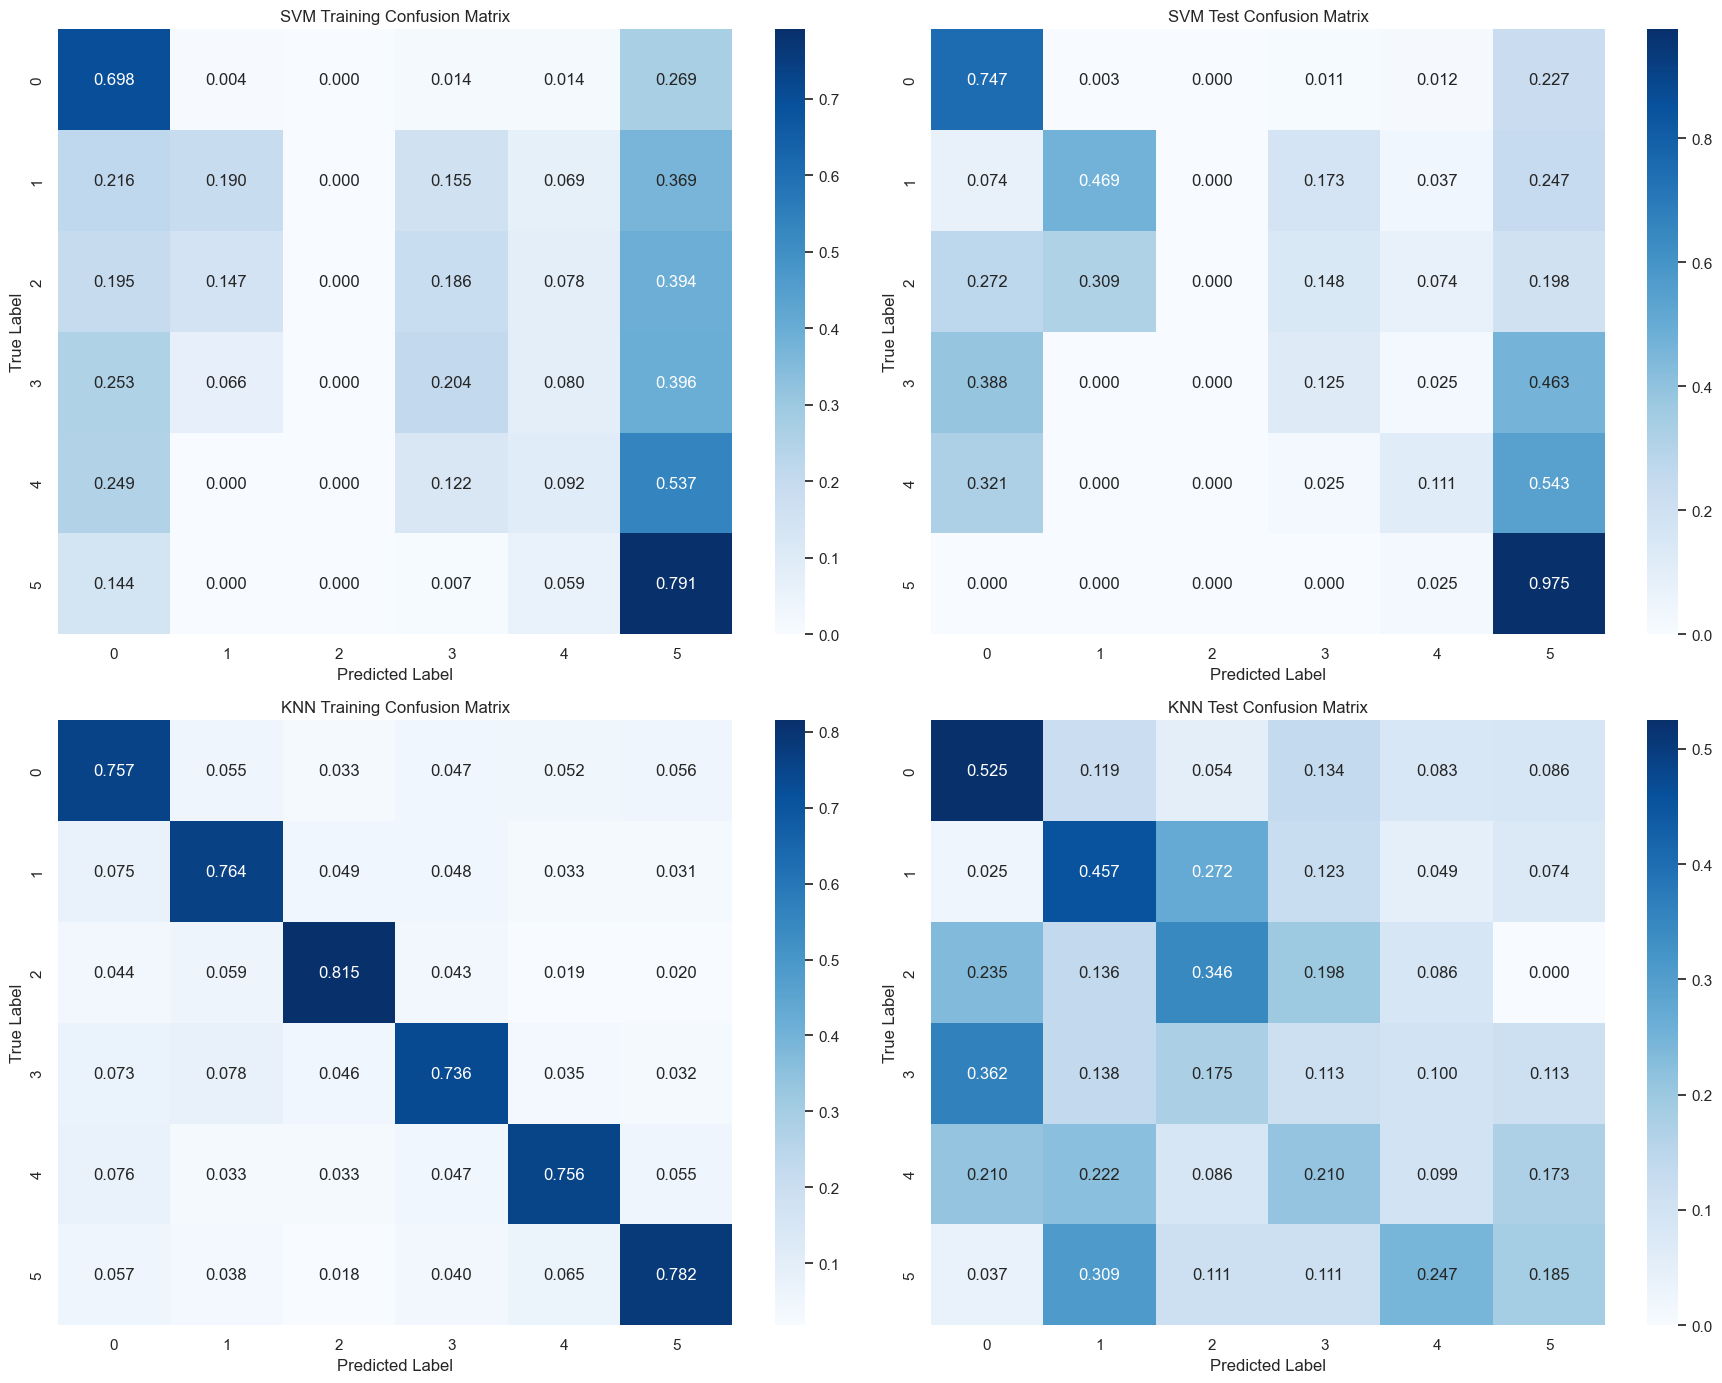

In [6]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Train the SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train_adasyn, y_train_adasyn)

# Train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn_model.fit(X_train_adasyn, y_train_adasyn)

# Predictions
svm_y_train_pred = svm_model.predict(X_train_adasyn)
svm_y_test_pred = svm_model.predict(X_test_selected)
knn_y_train_pred = knn_model.predict(X_train_adasyn)
knn_y_test_pred = knn_model.predict(X_test_selected)


# Evaluation function
def evaluate_model(y_train, y_train_pred, y_test, y_test_pred, model_name):
    print(f"\n{model_name} Classification Report (Test Data):")
    print(classification_report(y_test, y_test_pred, zero_division=0))

    test_acc = accuracy_score(y_test, y_test_pred)
    test_bal_acc = balanced_accuracy_score(y_test, y_test_pred)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_bal_acc = balanced_accuracy_score(y_train, y_train_pred)

    print(f"{model_name} Training Accuracy: {train_acc:.4f}")
    print(f"{model_name} Training Balanced Accuracy: {train_bal_acc:.4f}")
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")
    print(f"{model_name} Test Balanced Accuracy: {test_bal_acc:.4f}")

    return y_train_pred, y_test_pred


# Evaluate SVM
svm_y_train_pred, svm_y_test_pred = evaluate_model(y_train_adasyn, svm_y_train_pred, y_test, svm_y_test_pred, "SVM")

# Evaluate KNN
knn_y_train_pred, knn_y_test_pred = evaluate_model(y_train_adasyn, knn_y_train_pred, y_test, knn_y_test_pred, "KNN")

# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
plot_confusion_matrix(y_train_adasyn, svm_y_train_pred, 'SVM Training Confusion Matrix', axes[0, 0])
plot_confusion_matrix(y_test, svm_y_test_pred, 'SVM Test Confusion Matrix', axes[0, 1])
plot_confusion_matrix(y_train_adasyn, knn_y_train_pred, 'KNN Training Confusion Matrix', axes[1, 0])
plot_confusion_matrix(y_test, knn_y_test_pred, 'KNN Test Confusion Matrix', axes[1, 1])

plt.tight_layout()
plt.show()


### Features Extraction

In [ ]:
import pandas as pd

dfs = {idx: pd.DataFrame({'time': row['t'], 'Fz_s': row['Fz_s']})
       for idx, row in data.iterrows()}


In [ ]:
long_df = pd.concat([df.assign(id=idx) for idx, df in dfs.items()], ignore_index=True)

In [ ]:
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute

# Step 1: Extract features from the time series data.
extracted_features = extract_features(long_df, column_id="id", column_sort="time", column_value="Fz_s")

# Step 2: Impute any missing values that might have resulted from the extraction process.
imputed_features = impute(extracted_features)

# Step 3: Select features that significantly correlate with the labels.
relevant_features = select_features(imputed_features, data["label"])

In [ ]:
relevant_features = select_features(imputed_features, data["label"], fdr_level=0.0000001)  # Stricter selection
print(relevant_features.shape)

from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Compute mutual information scores
mi_scores = mutual_info_classif(imputed_features, data["label"])

# Create DataFrame with feature importance
feature_importance = pd.DataFrame({"feature": imputed_features.columns, "importance": mi_scores})

# Sort features by importance (highest first)
top_20_features = feature_importance.sort_values(by="importance", ascending=False).head(20)

# Extract the corresponding feature columns from the dataset
top_20_feature_names = top_20_features["feature"].tolist()
top_20_selected = imputed_features[top_20_feature_names]

print(f"Top 20 Most Informative Features:\n{top_20_selected.columns}")


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(top_20_selected, data["label"], test_size=0.2, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(data["label"]), yticklabels=set(data["label"]))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure feature_list contains only valid feature names
feature_list = top_20_selected.columns  # Adjust if necessary

for feature in feature_list:
    fig, axes = plt.subplots(1, 1, figsize=(8, 8))  # Two side-by-side plots

    # Scatter plot: Feature values in 2D space
    vmin, vmax = np.percentile(top_20_selected[feature], [1, 99])  # Clip extreme values
    sc = axes.scatter(data["posx"], data["posy"], c=np.clip(top_20_selected[feature], vmin, vmax),
                      cmap="viridis", vmin=vmin, vmax=vmax)

    # Add color bar
    cbar = plt.colorbar(sc, ax=axes)
    cbar.set_label(feature)

    axes.set_xlabel("Posx")
    axes.set_ylabel("Posy")
    axes.set_title(f"{feature} Distribution in 2D Space")

    # Adjust layout and remove default Matplotlib boxplot title
    plt.suptitle("")  # Remove default title generated by `boxplot`
    plt.tight_layout()  # Prevent overlap
    plt.show()
